# Normalizing Image Function for LEGO MiniFigure

Function to normalize each of the image based on file path given by the metadata

In [60]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision as tv
import torch
import pandas as pd
import skimage
from skimage import io, transform

## Starting with an example to get a better idea of how to write the function

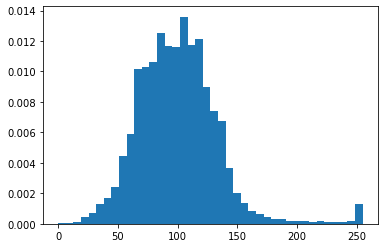

In [2]:
path = "marvel/0001/001.jpg"
img = Image.open(path)

#Converts image to a numpy array
img_nparr = np.array(img)
test = io.imread(path)
#Creating histogram
in_hist = plt.hist(test.ravel(), bins = 40, density = True)

### Convert PIL image to PyTorch Tensor image

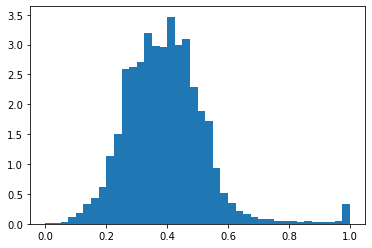

In [3]:
#Tensor transformation
transform1 = tv.transforms.Compose([
    tv.transforms.ToTensor()
])

#Putting image into function
tensor_img = transform1(img)
tensor_img_nparr = np.array(tensor_img)

#Another histogram
tensor_in_hist = plt.hist(tensor_img_nparr.ravel(), bins = 40, density = True)

In [4]:
#Finding mean and std of dataset
std, mean = torch.std_mean(tensor_img,[1,2])
print("Before normalizing --> Mean: " + str(mean) + " | STD: " + str(std))

Before normalizing --> Mean: tensor([0.4404, 0.3913, 0.3464]) | STD: tensor([0.1444, 0.1116, 0.1189])


### Normalizing based on mean/std

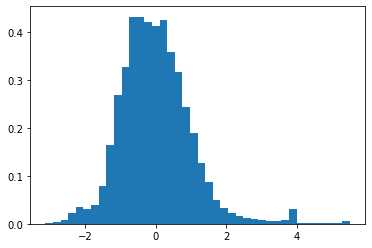

In [5]:
#Creating another transform func
transform1_norm = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean,std)
])

#Transforming image to normalized tensor
norm_img = transform1_norm(img)
norm_img_nparr = np.array(norm_img)

#Yet another histogram
tensor_in_hist = plt.hist(norm_img_nparr.ravel(), bins = 40, density = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 2.1653e-08,  1.2387e-07, -1.1967e-07]) tensor([1., 1., 1.])


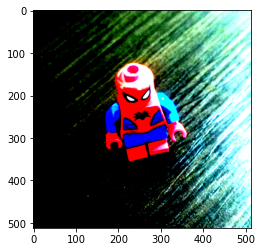

In [6]:
norm_img_view = norm_img_nparr.transpose(1,2,0)
plt.imshow(norm_img_view)

mean, std = norm_img.mean([1,2]), norm_img.std([1,2])
print(mean,std)

# Applying Above to Functions

df = pd.read_csv('data_all.csv')
df = df.drop(['Unnamed: 0','tmp_name','class_id'], axis = 1)

def show_image(path):
    img = Image.open(path)
    plt.imshow(img)
    
df.head()

In [28]:
df.shape

(425, 5)

In [91]:
df = pd.read_csv('data_all.csv')
#Convert the csv into a torch dataset
class LEGODataSet(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        #Dropping unnecessary columns
        self.df = df.drop(['Unnamed: 0','tmp_name','class_id'], axis = 1)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img = io.imread(row['path'])
        #Returns as dict
        sample = {'image': img}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample
    
#CHANGE ACCORDINGLY (ROOTDIR)
torch_lego = LEGODataSet(csv_file = 'data_all.csv',
                         root_dir = '/Users/danieltohti/Box Sync/Launch/Week 3 Project/NeuralNet_Project/Images',transform = tv.transforms.Compose([Rescale((256, 256))])
                         )

tens_transform = tv.transforms.Compose([
    tv.transforms.ToTensor()
])

dataloader = torch.utils.data.DataLoader(torch_lego)

In [87]:
norm_transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    #VERSATILE MEAN/STD FROM IMAGENET
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

#For loop to normalize all images
for i in range(len(torch_lego)):
    #Gets current image
    curr_img = torch_lego[i]['image']
    norm_img = norm_transform(curr_img)
    norm_img_nparr = np.array(norm_img)
    ### SAVE IMAGES TO DATASET BELOW ###
    view_img = np.array(norm_img).transpose(1,2,0)
    print(curr_img)
    if i==3:
        break
    

[[[ 93  86  68]
  [ 94  85  68]
  [ 96  87  70]
  ...
  [143 140 123]
  [141 138 121]
  [140 137 120]]

 [[ 96  89  71]
  [ 96  89  71]
  [ 99  90  73]
  ...
  [144 141 124]
  [143 140 123]
  [143 140 123]]

 [[101  94  76]
  [100  93  75]
  [103  96  78]
  ...
  [145 142 125]
  [145 142 125]
  [145 142 125]]

 ...

 [[ 80  70  60]
  [ 71  61  51]
  [ 67  57  47]
  ...
  [134 132 119]
  [141 139 126]
  [132 130 117]]

 [[ 76  66  56]
  [ 66  56  46]
  [ 61  53  42]
  ...
  [136 134 121]
  [132 130 117]
  [136 134 121]]

 [[ 69  59  49]
  [ 63  53  43]
  [ 65  57  46]
  ...
  [128 126 113]
  [131 129 116]
  [134 130 118]]]
[[[233 223 196]
  [233 223 196]
  [232 225 197]
  ...
  [153 151 136]
  [154 152 137]
  [155 153 138]]

 [[229 222 194]
  [229 222 194]
  [230 223 194]
  ...
  [153 151 136]
  [153 151 136]
  [153 151 136]]

 [[229 222 193]
  [228 221 192]
  [229 222 193]
  ...
  [153 151 136]
  [152 150 135]
  [152 150 135]]

 ...

 [[ 89  77  61]
  [ 89  77  61]
  [ 85  73  57]
  ..

# Resizing Images

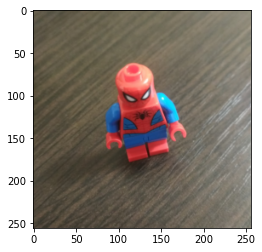

In [93]:
class Rescale(object):
    #output_size MUST be a tuple --> No need for simply int arg
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        
        return {'image': img}

plt.imshow(torch_lego[0]['image'])